# Pros and cons of the NIPALS algorithm

Group 1:

Iván Fernández Valencia

## What is the NIPALS algorithm?

**NIPALS** (Nonlinear Iterative Partial Least Squares) is an **iterative, component-by-component method** to extract **principal components** (for PCA) or **latent variables** (for PLS). Unlike a one-shot eigendecomposition, it alternates between **scores** and **loadings** to get **one component at a time**, **deflates** the data to remove what’s already explained, and repeats. A key perk is that it can be adapted to **handle missing values** without prior imputation [1][2].

## How is the NIPALS algorithm applied?

For PCA on a centered data matrix $X\in\mathbb{R}^{n\times p}$:

$$
X \;\approx\; T\,P^{\top} \quad\text{(rank-}A\text{ approximation)}
$$

Equivalently, component-wise:

$$
\\ X \;\approx\; \sum_{a=1}^{A} t_a\,p_a^{\top}\,
$$

* $X$: data matrix with **$n$** samples (rows) and **$p$** variables (columns).
* $T\in\mathbb{R}^{n\times A}$: **scores** (sample coordinates along each PC).
* $P\in\mathbb{R}^{p\times A}$: **loadings** (directions in variable space).
* $A$: number of components.
* The residual after $A$ components: $E^{(A)} = X - T P^{\top}$.

## How does the NIPALS algorithm work? (PCA version)

Given centered $X$:

**For each component $a=1,\dots,A$:**

1. **Initialize** a nonzero score vector $t$ (e.g., a column of $X$).
2. **Iterate until convergence:**

   * **Loadings update:** $p \leftarrow \dfrac{X^{\top} t}{t^{\top} t}$, then (optionally) normalize $p\leftarrow \dfrac{p}{\lVert p\rVert}$.
   * **Scores update:**

     * if $\lVert p\rVert=1$: $t \leftarrow X p$
     * otherwise: $t \leftarrow \dfrac{X p}{p^{\top} p}$.
   * **Convergence test:** stop when $\dfrac{\lVert t_{\text{new}}-t_{\text{old}}\rVert}{\lVert t_{\text{old}}\rVert} < \text{tol}$.
3. **Store** $t_a\leftarrow t$, $p_a\leftarrow p$.
4. **Deflate:** $X \leftarrow X - t_a p_a^{\top}$ (removes the rank-1 part just extracted).


**Missing-data (Martens & Martens) adaptation:**

When computing $p_k$, use only rows $i$ where $X_{ik}$ is observed; when computing $t_i$, use only columns $k$ observed in row $i$. Deflate only observed cells. This lets NIPALS proceed without pre-imputation (can slow or fail if missingness is heavy).

## Pros

* **Works with missing data (no pre-imputation required):**
  Using per-row/column masks in the updates (Martens & Martens) lets you fit PCA despite NaNs. [1]
* **Memory-friendly and scalable:**
  Operates via matrix-vector products, it is not needed to store large covariance matrices or compute a full SVD if you only want the **first few** PCs.
* **Efficient when you only need a few components:**
  Gets PC1, PC2, … in order—handy for exploratory analysis and early stopping.
* **Naturally supports incremental workflows:**
  Component-wise extraction and deflation suit iterative pipelines and diagnostics.

## Cons

* **Orthogonality drift / numerical accumulation:**
  Because components are extracted sequentially with deflation, later components can lose perfect orthogonality (round-off). Re-orthogonalization can help [3].
* **Slower than modern SVD when you need many components:**
  If you want **most** singular vectors, randomized SVD or eigensolvers are typically faster and more stable.
* **Convergence quirks:**
  With close leading eigenvalues, convergence can be slow; results can depend on initialization and tolerances.
* **Deflation sensitivity:**
  Different deflation schemes and scaling conventions can affect numerical behavior; errors accumulate across components.
* **Missing-data caveat:**
  Although it “works” with the adaptations, the possibility of facing problem increase with the amount of missing data.

# Practical example of this method
In order to implement this method, a data set that represents the Wisconsin Diagnostic Breast Cancer (WDBC) dataset. Each sample comes from a digitized fine-needle aspirate (FNA) image of a breast mass, and the features summarize cell-nuclei morphology (e.g., radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal dimension). These 10 measures are provided as mean, standard error, and “worst” values, yielding 30 real-valued features per case. The goal is binary classification: predicting whether a tumor is malignant or benign. [4]

In [1]:
# Import python libraries used in this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo 

%matplotlib widget 


In [2]:
# Import the data from UCI repository
  
# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
Y = breast_cancer_wisconsin_diagnostic.data.targets 

print_data = False

if print_data:  
    # metadata 
    print("-"*10+" Metadata "+"-"*10)
    print(breast_cancer_wisconsin_diagnostic.metadata) 
    print("-·"*25)  
    # variable information 
    print("-"*10+" Variable information "+"-"*10)
    print(breast_cancer_wisconsin_diagnostic.variables) 
    print("-·"*25)  

In [3]:
# Center the columns of X

# We will skip those columns that are not numerical
Xc = X.select_dtypes('number')

# Calculate the mean value of each column of the dataframe
means = Xc.mean(axis=0)            

# Create a copy so we don't lose the original data and substract the mean value to the numerical columns
X_centered = X.copy()
X_centered[Xc.columns] = Xc - means

In [4]:
# Now, we can analyse the dimensions of the matrix that we are working with

n = X_centered.shape[0]
p = X_centered.shape[1]
X_np = X_centered.to_numpy()

# And then, we create the matices P (loadings) and T (scores) knowing the dimensions that the should have;
# P should have p x k dimension, being k = min(n,p). In this case n = 569 and p = 30, then P should be 30 x 30 
k = min(n,p)
P_np = np.zeros((p, k), dtype=float)

# T should have n x k dimensions, being k = min(n,p). In this case n = 569 and p = 30, then P should be 569 x 30 

T_np = np.zeros((n, k), dtype=float)

print("Number of rows (n): "+ str(n))
print("Number of columns (p): "+ str(p))
print("The dimension k for the T and P matrix : "+ str(k))

Number of rows (n): 569
Number of columns (p): 30
The dimension k for the T and P matrix : 30


In [5]:
# ITERATIVE PROCESS CONFIGURATION

# Since this method is iterative, in order to create a safe code, a maximum number of iterations should be defined
max_iter = 500

# And also a tolerance for the iteration to be considered as valid
tol = 1e-8

# And we calculate the eps of this machine to avoid also convergential problems
eps = np.finfo(float).eps

In [6]:
# Make a copy that will be defleated in the loops
X_deflated_np = X_np.copy()

# Create a dataframe to storage the process of convergence for each "a" value
a_max_range = np.linalg.matrix_rank(X_np)
index_info = pd.RangeIndex(0, a_max_range, name="a")
convergence_info = pd.DataFrame({
    "iter_number": pd.Series(index = index_info, dtype="int64"),
    "variation_t": pd.Series(index = index_info, dtype="float64"),
    "eigenvalue": pd.Series(index = index_info, dtype="float64"),
    "convergence": pd.Series(index = index_info, dtype="bool"),
})

for a in range(a_max_range):

    t_a = X_deflated_np[:, a].copy()

    iter = 0
    convergence = False
    variation_t = 999

    while iter < max_iter:

        # Update the loading column a
        p_a = np.matmul(X_deflated_np.T,t_a) / np.matmul(t_a.T,t_a)

        # Nomarlize the value of the column
        p_a_norm = p_a / np.sqrt(np.matmul(p_a.T,p_a))

        # Update the score column a 
        t_a_new = np.matmul(X_deflated_np,p_a_norm) / np.sqrt(np.matmul(p_a_norm.T,p_a_norm))

        # And then, the variation of the score column is compared to the tolerance, multiplicating both size of the inequation to the norm of the t_a to avoid dividing by zero
        variation_t = np.linalg.norm(t_a_new - t_a)
        tol_adapt = tol * max(np.linalg.norm(t_a), eps)

        if variation_t <= tol_adapt:
            convergence = True
            t_a = t_a_new
            break
        else:
            t_a = t_a_new
            iter+=1
    
    # Then, if the interation converged, P and T matrix are updated for the a position and the X matrix is defleated. 
    P_np[:,a] = p_a_norm
    T_np[:,a] = t_a

    # It is necessary to adapt the shape of the t_a and p_a elements, because we need them to be 2D so we are able to traspose it
    t_a = t_a.reshape(-1,1)
    p_a_norm = p_a_norm.reshape(-1,1)
    deflation_term = np.matmul(t_a, p_a_norm.T) 

    # And then, make the substraction

    X_deflated_np = X_deflated_np - deflation_term

    # Update the dataframe with the info of this loop

    eigenvalue_a = np.matmul(t_a.T,t_a)[0,0]

    convergence_info.loc[a, ['iter_number','variation_t', 'eigenvalue', 'convergence']] = [iter, variation_t, round(eigenvalue_a,4), convergence]

In [7]:
print(convergence_info)

    iter_number   variation_t    eigenvalue  convergence
a                                                       
0           5.0  4.437819e-06  2.520685e+08         True
1           8.0  9.306695e-06  4.152137e+06         True
2           8.0  9.884372e-07  3.997776e+05         True
3          55.0  1.436096e-06  3.104048e+04         True
4           7.0  3.704700e-07  2.265753e+04         True
5          32.0  3.448829e-07  1.706606e+03         True
6          13.0  2.396325e-07  1.031108e+03         True
7          21.0  1.327363e-07  2.109931e+02         True
8          28.0  5.794619e-08  8.833170e+01         True
9          20.0  3.571278e-08  4.774680e+01         True
10         12.0  3.023919e-08  1.795390e+01         True
11         23.0  1.013194e-08  4.258500e+00         True
12         44.0  1.007473e-08  1.795800e+00         True
13         40.0  8.736795e-09  1.227700e+00         True
14         25.0  6.652352e-09  7.535000e-01         True
15         36.0  3.794619e-09  

In [7]:
# Representation configuration

# Here we can define which PC we want to represent together. Only remeber that you have to write the number - 1. 
PC_a = 0
PC_b = 1
PC_c = 2


In [8]:
# This modification in the shape is needed to operate and to represent it
Y = Y.to_numpy().reshape(-1,1)

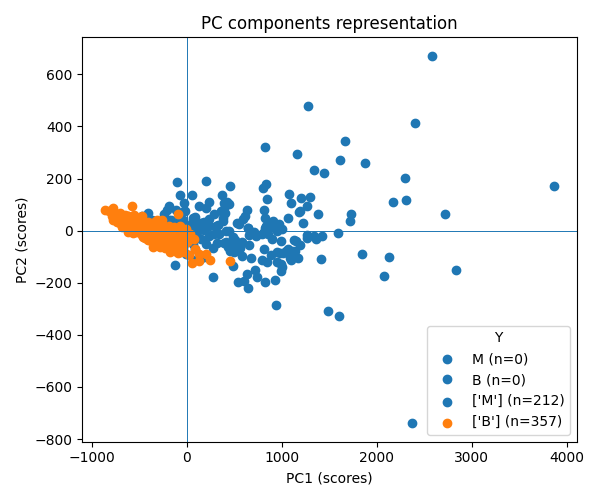

In [9]:
# Shapes
n = T_np.shape[0]

T_x = T_np[:, PC_a]
T_y = T_np[:, PC_b]

# Plot settings
title = "PC components representation"
class_order = ["M", "B"]           # force these classes to appear
force_legend_classes = True        # show legend entries even if n=0
legend_with_counts = True          # show counts in legend labels

plt.figure(figsize=(6, 5))

if Y is None:
    plt.scatter(T_x, T_y)
else:
    Y_arr = np.asarray(list(Y))
    if Y_arr.shape[0] != n:
        raise ValueError(f"Y length {Y_arr.shape[0]} does not match n={n}.")

    # Try numeric; otherwise treat as categorical
    is_numeric = False
    try:
        Y_num = Y_arr.astype(float)
        is_numeric = np.isfinite(Y_num).all()
    except Exception:
        is_numeric = False

    if is_numeric:
        sc = plt.scatter(T_x, T_y, c=Y_num)
        plt.colorbar(sc, label="Y")
    else:
        # Clean labels to be robust against whitespace/case
        Y_str = np.array([str(v).strip().upper() for v in Y_arr])

        # Build plotting order: force M/B first, then any other categories present
        unique_cats = list(dict.fromkeys(Y_str))  # preserves first-appearance order
        cats = []
        for c in class_order:
            if c not in cats:
                cats.append(c)
        for c in unique_cats:
            if c not in cats:
                cats.append(c)

        # Scatter per category; ensure legend entries for missing classes if requested
        handles, labels = [], []
        from matplotlib.lines import Line2D

        for cat in cats:
            mask = (Y_str == cat)
            count = int(mask.sum())
            if count > 0:
                h = plt.scatter(T_x[mask], T_y[mask], label=cat)
            elif force_legend_classes and cat in class_order:
                # Proxy handle so the class appears in the legend even with zero points
                h = Line2D([], [], marker='o', linestyle='None')
            else:
                continue  # skip truly absent, non-forced classes
            handles.append(h)
            labels.append(f"{cat} (n={count})" if legend_with_counts else cat)

        if handles:
            plt.legend(handles, labels, title="Y")

# Axes styling
plt.axhline(0, linewidth=0.7)
plt.axvline(0, linewidth=0.7)
plt.xlabel(f"PC{PC_a+1} (scores)")
plt.ylabel(f"PC{PC_b+1} (scores)")
plt.title(title)
plt.tight_layout()
plt.show()

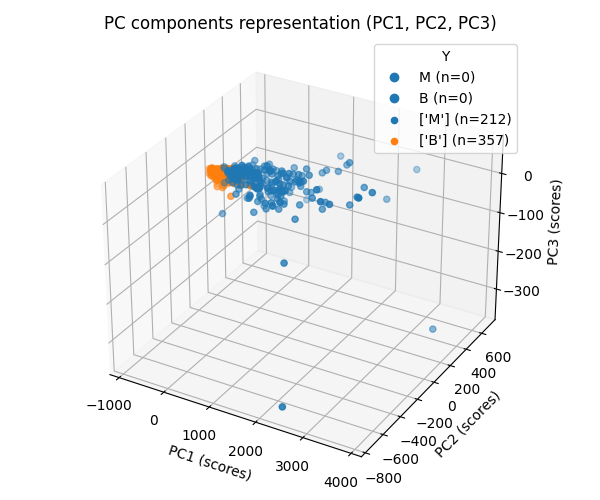

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---- Choose 3 PCs (zero-based indices) ----
class_order = ["M", "B"]            # force these classes to appear
legend_with_counts = True

# ---- Shapes and sanity checks ----
n, A = T_np.shape
for idx in (PC_a, PC_b, PC_c):
    if not (0 <= idx < A):
        raise ValueError(f"PC index {idx} out of range [0, {A-1}]")

Tx = T_np[:, PC_a]
Ty = T_np[:, PC_b]
Tz = T_np[:, PC_c]

# ---- 3D plot ----
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
title = f"PC components representation (PC{PC_a+1}, PC{PC_b+1}, PC{PC_c+1})"

if Y is None:
    ax.scatter(Tx, Ty, Tz)
else:
    Y_arr = np.asarray(list(Y))
    if Y_arr.shape[0] != n:
        raise ValueError(f"Y length {Y_arr.shape[0]} does not match n={n}.")

    # Try numeric; otherwise treat as categorical
    is_numeric = False
    try:
        Y_num = Y_arr.astype(float)
        is_numeric = np.isfinite(Y_num).all()
    except Exception:
        is_numeric = False

    if is_numeric:
        sc = ax.scatter(Tx, Ty, Tz, c=Y_num)
        fig.colorbar(sc, ax=ax, label="Y")
    else:
        # Clean labels to be robust to whitespace/case
        Y_str = np.array([str(v).strip().upper() for v in Y_arr])

        # Build plotting order: forced classes first, then any others found
        seen_order = list(dict.fromkeys(Y_str))  # preserves first-appearance order
        cats = [c for c in class_order] + [c for c in seen_order if c not in class_order]

        handles, labels = [], []
        for cat in cats:
            mask = (Y_str == cat)
            count = int(mask.sum())
            if count > 0:
                h = ax.scatter(Tx[mask], Ty[mask], Tz[mask], label=cat)
            else:
                # Proxy so class appears even with 0 points
                h = Line2D([], [], marker='o', linestyle='None')
            handles.append(h)
            labels.append(f"{cat} (n={count})" if legend_with_counts else cat)

        ax.legend(handles, labels, title="Y")

# ---- Axes & view ----
ax.set_xlabel(f"PC{PC_a+1} (scores)")
ax.set_ylabel(f"PC{PC_b+1} (scores)")
ax.set_zlabel(f"PC{PC_c+1} (scores)")
ax.set_title(title)
# Optional: set an initial view angle (you can still rotate interactively)
# ax.view_init(elev=20, azim=35)

plt.tight_layout()
plt.show()


# Handling Missing Data in NIPALS (Martens & Martens–style)

In the reference [1], the show an adaptative **NIPALS–PCA** algorithm to datasets with missing entries, following the idea attributed to **Martens & Martens (2001, p. 381)** [5].

## Core idea

When updating a component in NIPALS, **only use observed values** for the relevant row/column:

- **Updating a loading for variable \(k\)** (a column of \(X\)):  
  ignore samples \(i\) where $(X_{ik})$ is missing when forming the regression of \(x_k\) on the current score vector \(t_a\).

- **Updating a score for sample \(i\)** (a row of \(X\)):  
  ignore variables \(k\) where $(X_{ik})$ is missing when projecting that row onto the current loading vector \(p_a\).

This “skip-missing” rule lets NIPALS proceed **without pre-imputing** \(X\). This means that we just skip the value, not substitute the value for another.

## Update formulas (using only observed entries)

**Loading for variable \(k\)**:
$$
p_{k,h}
\;=\;
\frac{\sum\limits_{i \in \Omega_k} X^{(h-1)}_{ik}\, t_{i,h}}
{\sum\limits_{i \in \Omega_k} t_{i,h}^2}
\quad\text{(set to 0 if the denominator is 0).}
$$

Vector form (conceptually):  
$\displaystyle p_h \leftarrow \frac{X^{(h-1)\top} t_h}{t_h^\top t_h}$, **but** each $p_{k,h}$ uses only $i\in\Omega_k$.

**Score for sample \(i\)**:
$$
t_{i,h}
\;=\;
\frac{\sum\limits_{k \in \Omega_i} X^{(h-1)}_{ik}\, p_{k,h}}
{\sum\limits_{k \in \Omega_i} p_{k,h}^2}
\quad\text{(set to 0 if the denominator is 0).}
$$

Vector form (conceptually):  
$\displaystyle t_h \leftarrow \frac{X^{(h-1)} p_h}{p_h^\top p_h}$, **but** each $t_{i,h}$ uses only $k\in\Omega_i$.

Many implementations also **normalize** $p_h$ (e.g., $\|p_h\|=1$ after each update; the scaling between \(t_h\) and \(p_h\) does not affect the rank-1 reconstruction or deflation.

## Deflation with missing data

After storing \(t_h\) and \(p_h\), deflate **only at observed cells**:

$$X^{(h)}_{ik}
\;=\;
\begin{cases}
X^{(h-1)}_{ik} - t_{i,h}\,p_{k,h}, & \text{if } X^{(h-1)}_{ik} \text{ observed}, \\
\text{(keep as missing)}, & \text{otherwise.}
\end{cases}
$$

This prevents NaNs from “spreading” through arithmetic.

In [11]:
def mask_random_fraction(X, frac=0.2, seed=None, copy=True):
    """Set ~frac of entries to NaN at random."""
    rng = np.random.default_rng(seed)
    Xf = X.astype(float, copy=copy)         # ints can't hold NaN
    mask = (rng.random(Xf.shape) < frac)    # True where we'll drop
    # don't overwrite existing NaNs if any:
    if np.isnan(Xf).any():
        mask &= ~np.isnan(Xf)
    Xf[mask] = np.nan
    return Xf, mask

In [12]:
# Here we will delete 

X_missing_np, missing_mask = mask_random_fraction(X_np.copy(), frac=0.1)

In [13]:
X_deflated_np = X_missing_np.copy() # will be deflated in-place
obs_mask = np.isfinite(X_deflated_np) # True where observed


for a in range(a_max_range):
    # Initialization: use column a (as in your code); replace NaNs by 0 for init
    t_a = X_deflated_np[:, a].copy() if a < p else np.zeros(n)
    t_a = np.where(np.isfinite(t_a), t_a, 0.0)


    iter = 0
    convergence = False
    variation_t = 999.0


    while iter < max_iter:
        t_old = t_a.copy()


        # ---- Update loading p_a with per-variable masks (skip missing rows for each k) ----
        p_a = np.zeros(p, dtype=float)
        for k_idx in range(p):
            mk = obs_mask[:, k_idx] # rows where X is observed in column k
            if mk.any():
                tk = t_a[mk]
                xk = X_deflated_np[mk, k_idx]
                den = float(tk @ tk)
                p_a[k_idx] = (float(xk @ tk) / den) if den > eps else 0.0
            # else leave 0.0


        # Normalize p_a (this step is optional)
        pn = np.linalg.norm(p_a)
        p_a_norm = p_a / pn if pn > eps else p_a


        # ---- Update scores t_a with per-row masks (skip missing columns in each row) ----
        t_a_new = np.zeros(n, dtype=float)
        for i in range(n):
            mi = obs_mask[i, :] # columns observed for this row i
            if mi.any():
                pi = p_a_norm[mi]
                xi = X_deflated_np[i, mi]
                den2 = float(pi @ pi)
                t_a_new[i] = (float(xi @ pi) / den2) if den2 > eps else 0.0
        


        # ---- Convergence test ----
        variation_t = np.linalg.norm(t_a_new - t_a)
        tol_adapt = tol * max(np.linalg.norm(t_a), eps)
        t_a = t_a_new


        if variation_t <= tol_adapt:
            convergence = True
            break
        else:
            iter += 1


    # Save component
    P_np[:, a] = p_a_norm
    T_np[:, a] = t_a


    # ---- Deflation: subtract rank-1 outer product ONLY on observed cells ----
    outer = np.outer(t_a, p_a_norm) # (n, p)
    X_deflated_np[obs_mask] = X_deflated_np[obs_mask] - outer[obs_mask]
    # (Missing pattern unchanged; obs_mask stays valid)


    # Update convergence info
    eigenvalue_a = float(t_a @ t_a)
    convergence_info.loc[a, ['iter_number','variation_t','eigenvalue','convergence']] = [iter, variation_t, round(eigenvalue_a, 4), convergence]

In [14]:
print(convergence_info)

    iter_number   variation_t    eigenvalue  convergence
a                                                       
0           8.0  4.146513e-05  2.518588e+08         True
1          12.0  1.710840e-05  3.527379e+06         True
2          23.0  4.347151e-06  5.478678e+05         True
3          52.0  1.556773e-06  3.353687e+04         True
4           9.0  4.893218e-07  2.174799e+04         True
5          33.0  5.692080e-07  3.836584e+03         True
6          69.0  3.187059e-07  1.277665e+03         True
7          32.0  2.593912e-07  1.140268e+03         True
8          18.0  1.517003e-07  4.003012e+02         True
9         116.0  1.166522e-07  1.767209e+02         True
10         53.0  8.178255e-08  1.329297e+02         True
11         87.0  7.335445e-08  7.349860e+01         True
12        167.0  6.928813e-08  5.364020e+01         True
13         50.0  5.026806e-08  5.147280e+01         True
14         38.0  3.752495e-08  3.121480e+01         True
15         34.0  3.779684e-08  

In [15]:
# Representation configuration

# Here we can define which PC we want to represent together. Only remeber that you have to write the number - 1. 
PC_a = 0
PC_b = 1
PC_c = 2


In [16]:
# This modification in the shape is needed to operate and to represent it
try:
    Y = Y.to_numpy().reshape(-1,1)
except AttributeError:
    True

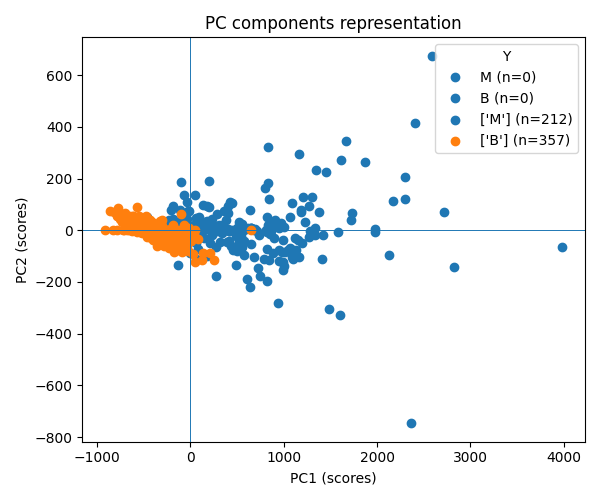

In [17]:
# Shapes
n = T_np.shape[0]

T_x = T_np[:, PC_a]
T_y = T_np[:, PC_b]

# Plot settings
title = "PC components representation"
class_order = ["M", "B"]           # force these classes to appear
force_legend_classes = True        # show legend entries even if n=0
legend_with_counts = True          # show counts in legend labels

plt.figure(figsize=(6, 5))

if Y is None:
    plt.scatter(T_x, T_y)
else:
    Y_arr = np.asarray(list(Y))
    if Y_arr.shape[0] != n:
        raise ValueError(f"Y length {Y_arr.shape[0]} does not match n={n}.")

    # Try numeric; otherwise treat as categorical
    is_numeric = False
    try:
        Y_num = Y_arr.astype(float)
        is_numeric = np.isfinite(Y_num).all()
    except Exception:
        is_numeric = False

    if is_numeric:
        sc = plt.scatter(T_x, T_y, c=Y_num)
        plt.colorbar(sc, label="Y")
    else:
        # Clean labels to be robust against whitespace/case
        Y_str = np.array([str(v).strip().upper() for v in Y_arr])

        # Build plotting order: force M/B first, then any other categories present
        unique_cats = list(dict.fromkeys(Y_str))  # preserves first-appearance order
        cats = []
        for c in class_order:
            if c not in cats:
                cats.append(c)
        for c in unique_cats:
            if c not in cats:
                cats.append(c)

        # Scatter per category; ensure legend entries for missing classes if requested
        handles, labels = [], []
        from matplotlib.lines import Line2D

        for cat in cats:
            mask = (Y_str == cat)
            count = int(mask.sum())
            if count > 0:
                h = plt.scatter(T_x[mask], T_y[mask], label=cat)
            elif force_legend_classes and cat in class_order:
                # Proxy handle so the class appears in the legend even with zero points
                h = Line2D([], [], marker='o', linestyle='None')
            else:
                continue  # skip truly absent, non-forced classes
            handles.append(h)
            labels.append(f"{cat} (n={count})" if legend_with_counts else cat)

        if handles:
            plt.legend(handles, labels, title="Y")

# Axes styling
plt.axhline(0, linewidth=0.7)
plt.axvline(0, linewidth=0.7)
plt.xlabel(f"PC{PC_a+1} (scores)")
plt.ylabel(f"PC{PC_b+1} (scores)")
plt.title(title)
plt.tight_layout()
plt.show()

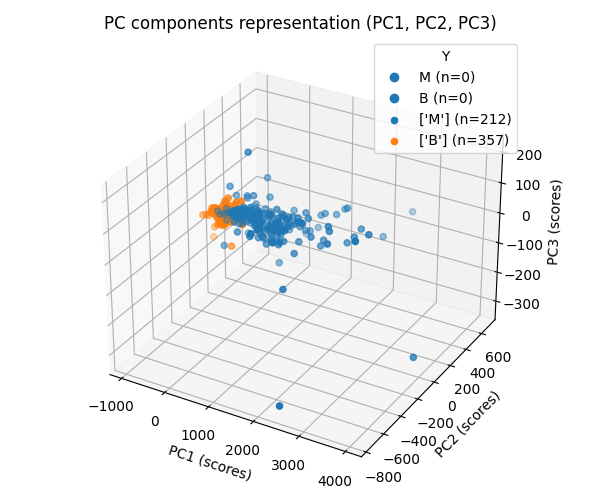

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---- Choose 3 PCs (zero-based indices) ----
class_order = ["M", "B"]            # force these classes to appear
legend_with_counts = True

# ---- Shapes and sanity checks ----
n, A = T_np.shape
for idx in (PC_a, PC_b, PC_c):
    if not (0 <= idx < A):
        raise ValueError(f"PC index {idx} out of range [0, {A-1}]")

Tx = T_np[:, PC_a]
Ty = T_np[:, PC_b]
Tz = T_np[:, PC_c]

# ---- 3D plot ----
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
title = f"PC components representation (PC{PC_a+1}, PC{PC_b+1}, PC{PC_c+1})"

if Y is None:
    ax.scatter(Tx, Ty, Tz)
else:
    Y_arr = np.asarray(list(Y))
    if Y_arr.shape[0] != n:
        raise ValueError(f"Y length {Y_arr.shape[0]} does not match n={n}.")

    # Try numeric; otherwise treat as categorical
    is_numeric = False
    try:
        Y_num = Y_arr.astype(float)
        is_numeric = np.isfinite(Y_num).all()
    except Exception:
        is_numeric = False

    if is_numeric:
        sc = ax.scatter(Tx, Ty, Tz, c=Y_num)
        fig.colorbar(sc, ax=ax, label="Y")
    else:
        # Clean labels to be robust to whitespace/case
        Y_str = np.array([str(v).strip().upper() for v in Y_arr])

        # Build plotting order: forced classes first, then any others found
        seen_order = list(dict.fromkeys(Y_str))  # preserves first-appearance order
        cats = [c for c in class_order] + [c for c in seen_order if c not in class_order]

        handles, labels = [], []
        for cat in cats:
            mask = (Y_str == cat)
            count = int(mask.sum())
            if count > 0:
                h = ax.scatter(Tx[mask], Ty[mask], Tz[mask], label=cat)
            else:
                # Proxy so class appears even with 0 points
                h = Line2D([], [], marker='o', linestyle='None')
            handles.append(h)
            labels.append(f"{cat} (n={count})" if legend_with_counts else cat)

        ax.legend(handles, labels, title="Y")

# ---- Axes & view ----
ax.set_xlabel(f"PC{PC_a+1} (scores)")
ax.set_ylabel(f"PC{PC_b+1} (scores)")
ax.set_zlabel(f"PC{PC_c+1} (scores)")
ax.set_title(title)
# Optional: set an initial view angle (you can still rotate interactively)
# ax.view_init(elev=20, azim=35)

plt.tight_layout()
plt.show()


# Orthogonalization

Note: in this screenshot from the reference [1], the subindex "h" is equivalent to the subindex "a" that I have been using in this notebook.

![orthogonalization explanation](.\images\image.png "Screenshot from [1]")


### Bibliography
[1] https://cran.r-project.org/web/packages/nipals/vignettes/nipals_algorithm.html

[2] https://hal.science/hal-01125940v1/document

[3] Andrecut, Mircea. 2009. “Parallel GPU Implementation of Iterative PCA Algorithms.” Journal of Computational Biology 16 (11): 1593–99. https://doi.org/10.1089/cmb.2008.0221.

[4] Wolberg, W., Mangasarian, O., Street, N., & Street, W. (1993). Breast Cancer Wisconsin (Diagnostic) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5DW2B.

[5] Martens, Harald, and Magni Martens. 2001. Multivariate Analysis of Quality: An Introduction. J.Wiley & Sons.

[6] https://pypi.org/project/nipals/